In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')
import seaborn
import os
import tempfile
import time

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex = True)

from functions import *
%load_ext autoreload
%autoreload 2

# Non interacting

## Time Series

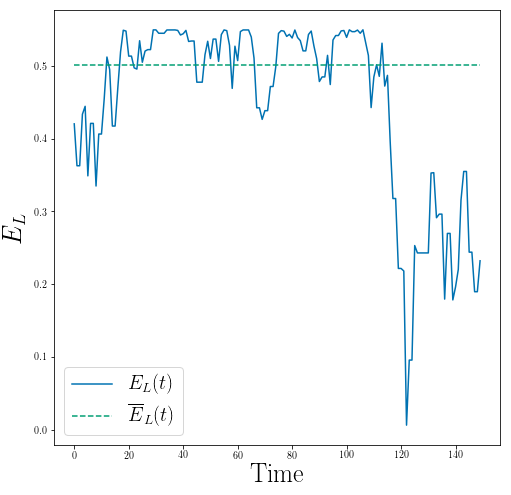

{'variance': 0.004588707836379035, 'time': 0.062505, 'acceptance-rate': 0.8535118103, 'energy-mean': 0.5021693646491423}


In [22]:
E, _, meta = run_MC(n=1, dims=1, n_mc=2**18, alpha=0.55, importance=False, step=1)
time_series_plot(E, saveas='../results/time-series-example.png')
print(meta)

## Configuration Comparison

In [11]:
make_configuration_table('../results/vmc_configurations.csv', n_mc=1000, importance=False, steps=(1, 0.1))
make_configuration_table('../results/vmc_imp_configurations.csv', n_mc=1000, importance=True, steps=(0.1, 0.01, 0.001))

Dims, Nparticles, Analytic, step, Energy, Variance, Acceptance, Time
1,   1, OFF , 1.000, 0.500000, 0.000000, 0.866, 5.960e-04
1,   1, OFF , 0.100, 0.500000, 0.000000, 0.995, 5.400e-04
1,   1, ON  , 1.000, 0.500000, 0.000000, 0.866, 3.890e-04
1,   1, ON  , 0.100, 0.500000, 0.000000, 0.995, 2.920e-04
1,  10, OFF , 1.000, 5.000000, 0.000000, 0.876, 9.675e-03
1,  10, OFF , 0.100, 4.999999, 0.000000, 0.997, 9.434e-03
1,  10, ON  , 1.000, 5.000000, 0.000000, 0.876, 1.353e-03
1,  10, ON  , 0.100, 5.000000, 0.000000, 0.997, 1.352e-03
1, 100, OFF , 1.000, 49.999990, 0.000000, 0.000, 5.754e-01
1, 100, OFF , 0.100, 49.999988, 0.000000, 0.999, 5.495e-01
1, 100, ON  , 1.000, 50.000000, 0.000000, 0.000, 9.845e-03
1, 100, ON  , 0.100, 50.000000, 0.000000, 0.999, 9.606e-03
1, 500, OFF , 1.000, 249.999947, 0.000000, 0.000, 1.350e+01
1, 500, OFF , 0.100, 249.999938, 0.000000, 0.999, 1.336e+01
1, 500, ON  , 1.000, 250.000000, 0.000000, 0.000, 4.214e-02
1, 500, ON  , 0.100, 250.000000, 0.000000, 0.999, 4

## Variation Plots

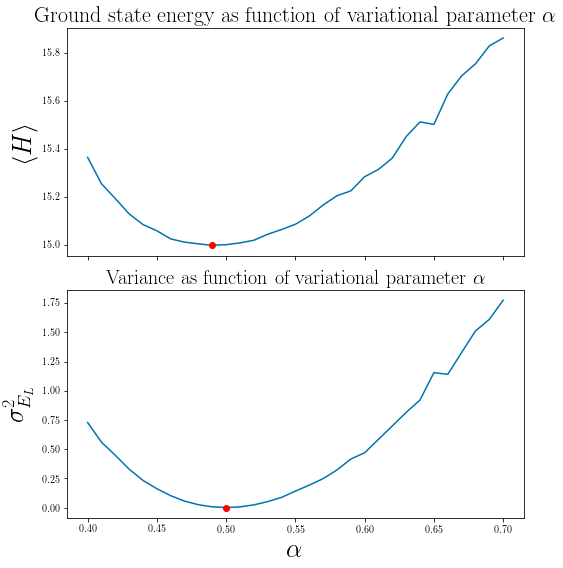

In [32]:
out = E_and_var_plot_for_alphas(np.linspace(0.4, 0.7, 31), 
                                n_mc=50000, importance=False, steps=[1],
                                dims=3, n=10, verbose=False,
                                saveas='../results/var-alpha-plot-noimp-50000.png')

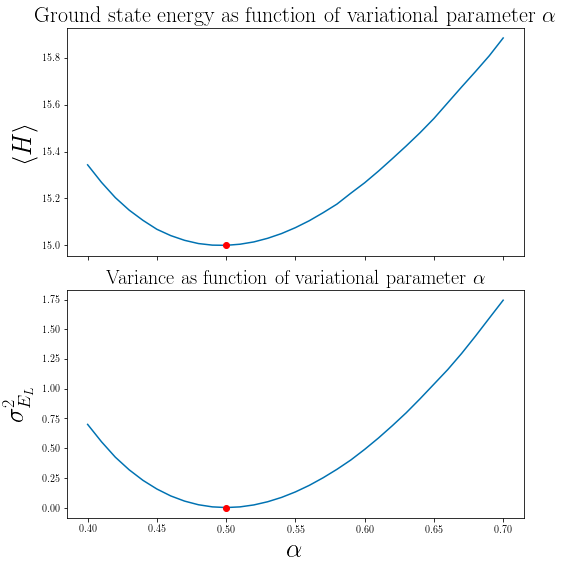

In [33]:
out = E_and_var_plot_for_alphas(np.linspace(0.4, 0.7, 31), 
                                n_mc=50000, importance=True, steps=[0.1],
                                dims=3, n=10, verbose=False,
                                saveas='../results/var-alpha-plot-imp-50000.png')

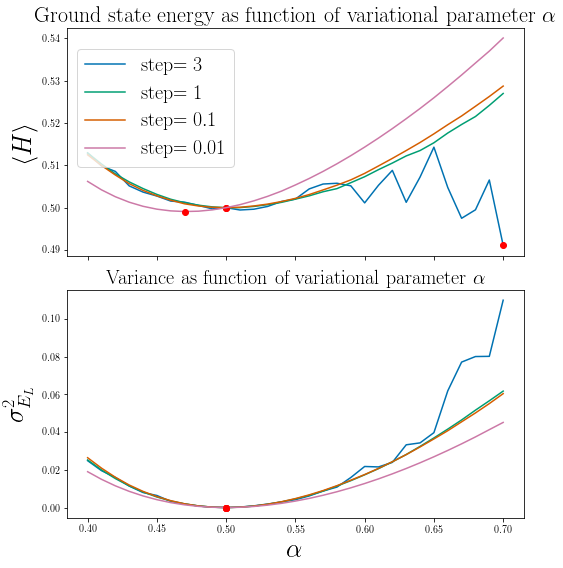

In [41]:
out = E_and_var_plot_for_alphas(np.linspace(0.4, 0.7, 31), 
                                n_mc=50000, importance=True, steps=[3, 1, 0.1, 0.01],
                                dims=1, n=1, verbose=False, saveas='../results/var-alpha-plot-imp-dts-50000.png')

Blocking warning: Blocked until stopped. Use more data if var != 0.


/home/bendik/drive/uio/10.semester/fys4411/project1/python/functions.py:222: RuntimeWarning: invalid value encountered in true_divide
  q = np.array([6.634897, 9.210340, 11.344867,


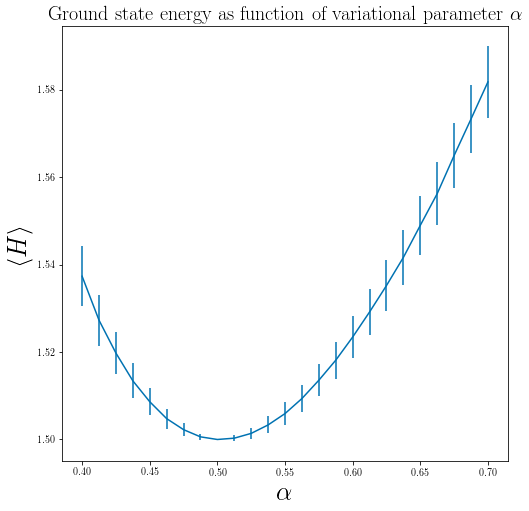

In [44]:
_ = proper_error_plot(np.linspace(0.4, 0.7, 25), importance=True, step=0.1, 
                      n_mc=2**14, dims=3, n=1, verbose=False,
                      saveas='../results/error-plot-3D-2-pow-14.png')

## Density plots

{'acceptance-rate': 0.735299,
 'energy-mean': 15.0,
 'time': 0.895677,
 'variance': 9.240653534886515e-31}

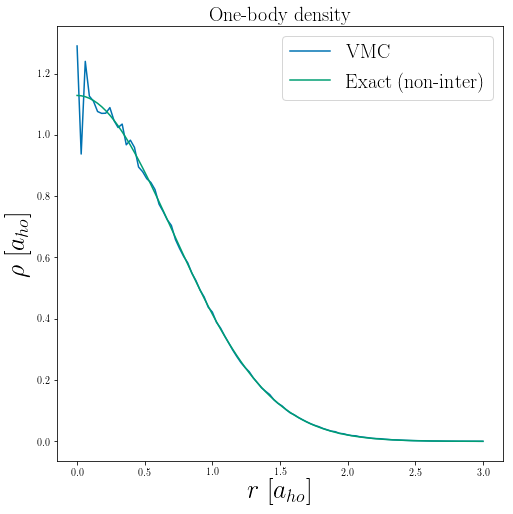

In [53]:
E, density, meta = run_MC(n=10, dims=3, alpha=0.5, beta=1, omega_z=1, a=0.00, 
                          importance=False, n_mc=int(1e6), step=1, 
                          n_bins=100, max_radius=3)
density_plot(density, max_radius=3, alpha=0.5, draw_exact=True,
             saveas='../results/one-body-3D-N10-noniter.png')
meta

integrated density: 1.0


{'acceptance-rate': 0.735299,
 'energy_mean': 15.0,
 'time': 2.311271,
 'variance': 9.2406535348865145e-31}

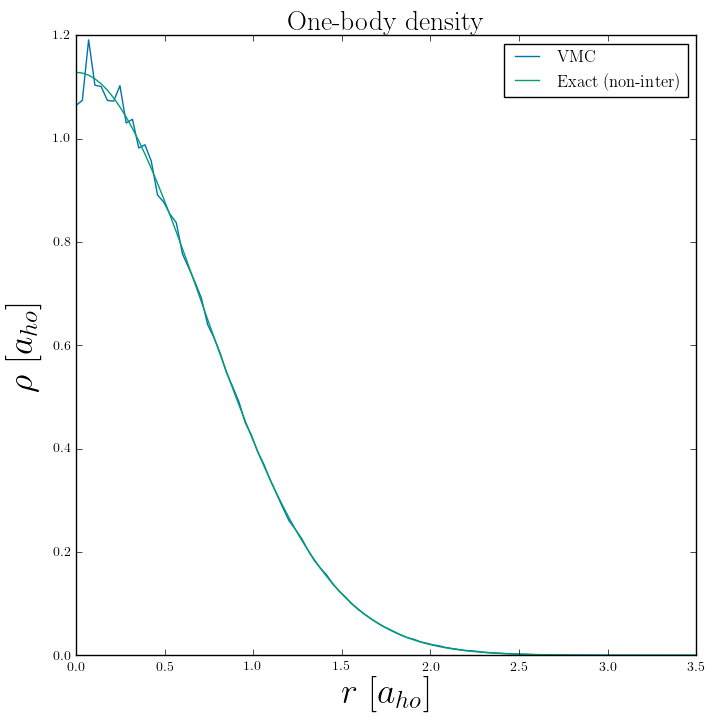

In [11]:
E, density, meta = run_MC(n=10, dims=3, alpha=0.5, beta=1, omega_z=1, a=0.00, importance=False, n_mc=int(1e6), step=1, n_bins=100, max_radius=3.5)
density_plot(density, max_radius=3.5, alpha=0.5, draw_exact=True)
meta

{'acceptance-rate': 0.962837,
 'energy_mean': 24.14215000000001,
 'time': 1.000825,
 'variance': 1.2867815782253553e-28}

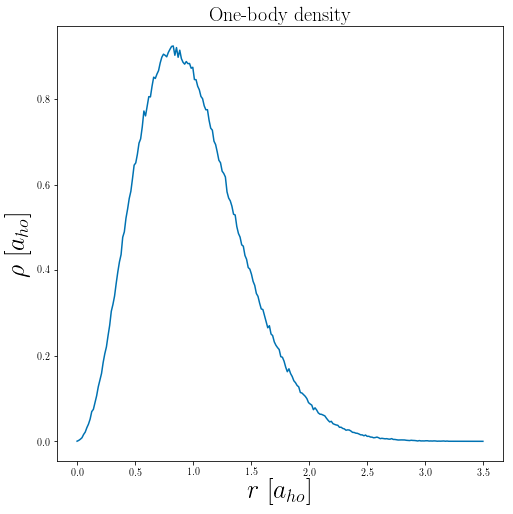

In [66]:
E, density, meta = run_MC(n=10, dims=3, alpha=0.5, beta=2.82843, omega_z=2.82843, a=0, importance=True, n_mc=int(1e6), step=0.1, n_bins=250, max_radius=3.5)
density_plot(density, max_radius=3.5)
meta

# Interacting system

{'acceptance-rate': 0.674958,
 'energy_mean': 24.39834388604039,
 'time': 61.185218,
 'variance': 0.0032426202213398547}

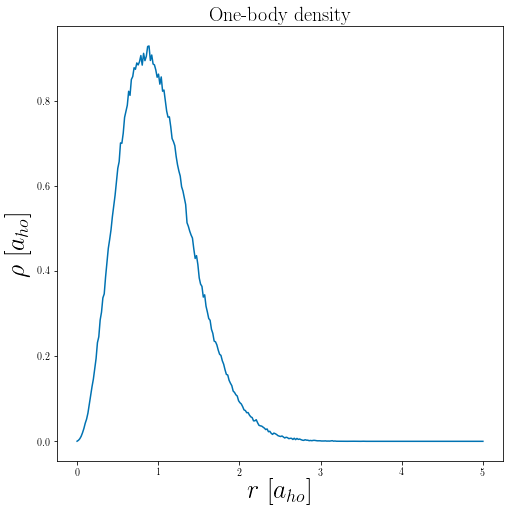

In [57]:
E_holy, density_holy, meta_holy = run_MC(n=10, dims=3, alpha=0.5, beta=2.82843, omega_z=2.82843, a=0.0043, importance=False, n_mc=int(1e6), step=1, n_bins=300, max_radius=5, filename='../results/interacting-data')
density_plot(density_holy, max_radius=5)
meta_holy

{'acceptance-rate': 0.674958,
 'energy_mean': 24.395577164535162,
 'time': 100.825622,
 'variance': 0.8603206456222581}

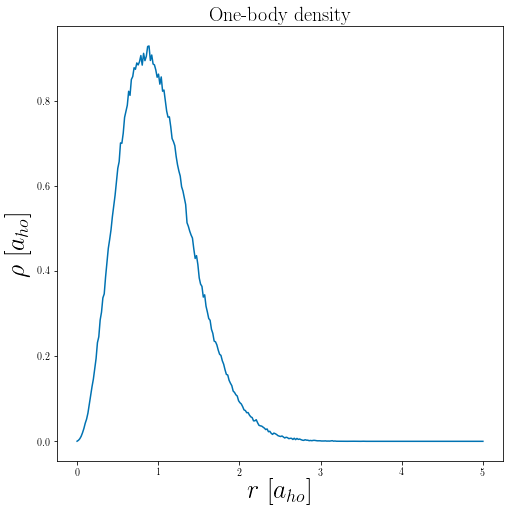

In [56]:
E_holy_num, density_holy_num, meta_holy_num = run_MC(analytic=False, n=10, dims=3, alpha=0.5, beta=2.82843, omega_z=2.82843, a=0.0043, importance=False, n_mc=int(1e6), step=1, n_bins=300, max_radius=5, filename='../results/interacting-data_numeric')
density_plot(density_holy_num, max_radius=5)
meta_holy_num

[10] [10] [ 15.] [  8.92788900e-31]


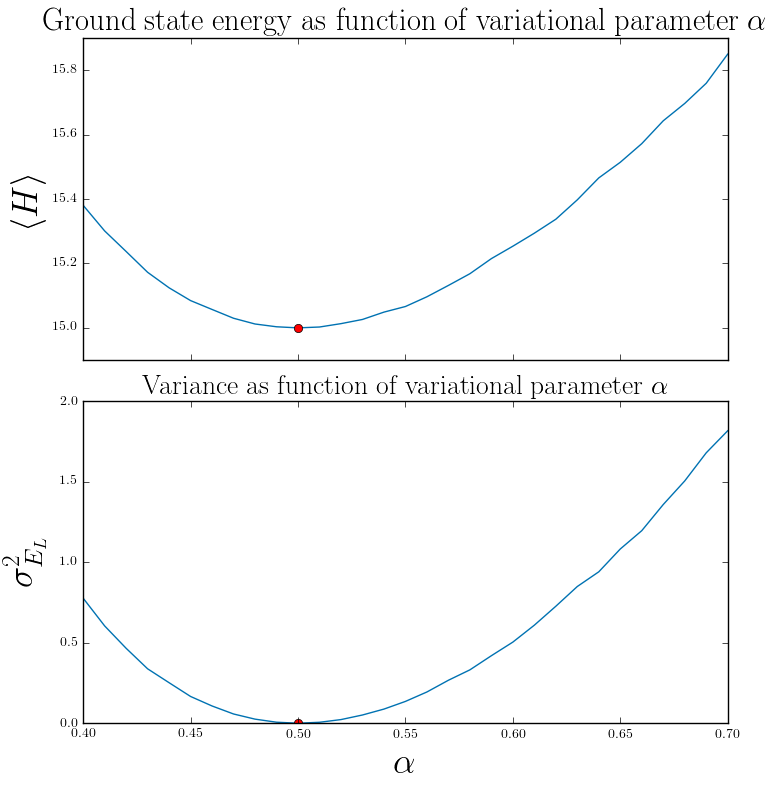

In [4]:
out = E_and_var_plot_for_alphas(np.linspace(0.4, 0.7, 31), 
                          n_mc=2**18, importance=False, steps=[1],
                          dims=3, n=10)

[30 30 30] [10 10 10] [-10.13709625 -42.49457941 -76.92417208] [ 0.  0.  0.]


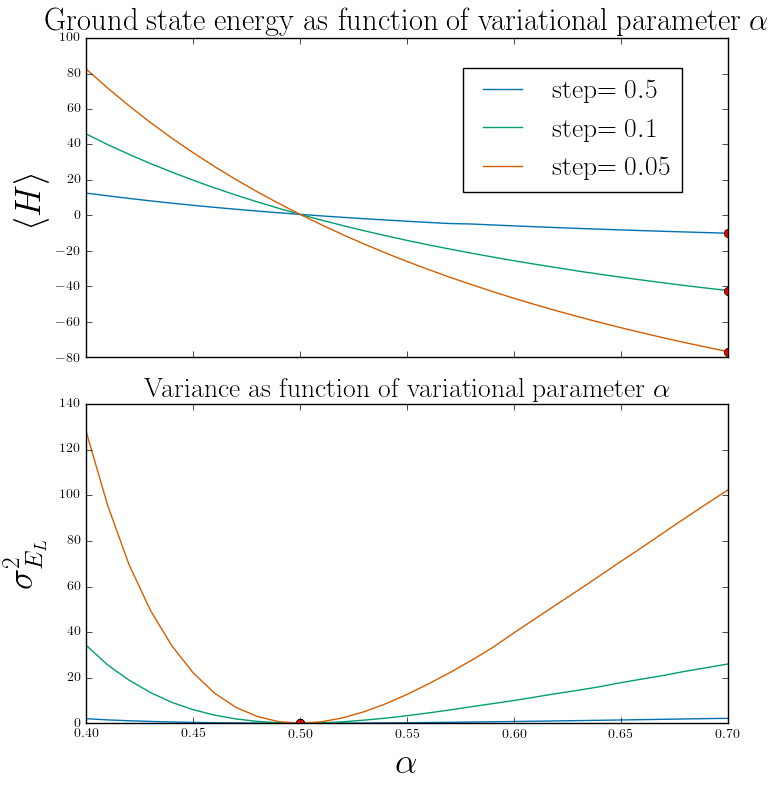

In [12]:
out = E_and_var_plot_for_alphas(np.linspace(0.4, 0.7, 31), 
                          n_mc=2**20, importance=True, steps=[0.5, 0.1, 0.05],
                          dims=1, n=1)

{'importance': True, 'n_mc': 262144, 'dims': 1, 'n': 1, 'step': 1.5, 'alpha': 0.40000000000000002} ar= 0.0071334838867
{'importance': True, 'n_mc': 262144, 'dims': 1, 'n': 1, 'step': 1.5, 'alpha': 0.41250000000000003} ar= 0.0099411010742
{'importance': True, 'n_mc': 262144, 'dims': 1, 'n': 1, 'step': 1.5, 'alpha': 0.42500000000000004} ar= 0.033958435059
{'importance': True, 'n_mc': 262144, 'dims': 1, 'n': 1, 'step': 1.5, 'alpha': 0.4375} ar= 0.15743255615
{'importance': True, 'n_mc': 262144, 'dims': 1, 'n': 1, 'step': 1.5, 'alpha': 0.45000000000000001} ar= 0.4150428772
{'importance': True, 'n_mc': 262144, 'dims': 1, 'n': 1, 'step': 1.5, 'alpha': 0.46250000000000002} ar= 0.63702774048
{'importance': True, 'n_mc': 262144, 'dims': 1, 'n': 1, 'step': 1.5, 'alpha': 0.47499999999999998} ar= 0.79336547852
{'importance': True, 'n_mc': 262144, 'dims': 1, 'n': 1, 'step': 1.5, 'alpha': 0.48749999999999999} ar= 0.9088973999
{'importance': True, 'n_mc': 262144, 'dims': 1, 'n': 1, 'step': 1.5, 'alph

/Users/bendik/drive/uio/10.semester/fys4411/project1/python/functions.py:205: RuntimeWarning: invalid value encountered in true_divide
  M = (np.cumsum(((gamma / s)**2 * 2**np.arange(1, d + 1)[::-1])[::-1] ))[::-1]


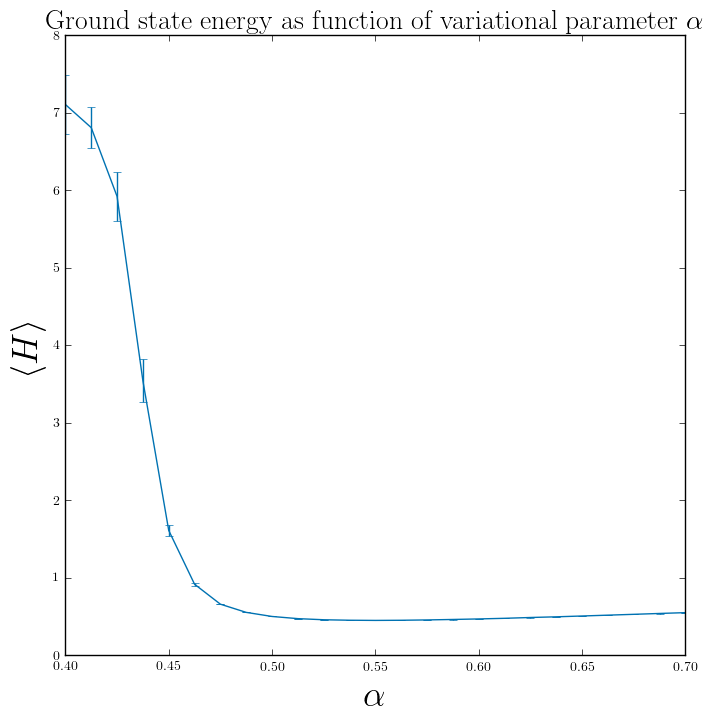

In [5]:
_ = proper_error_plot(np.linspace(0.4, 0.7, 25), importance=True, 
                      n_mc=2**18, dims=1, n=1, step=1.5)

/Users/bendik/drive/uio/10.semester/fys4411/project1/python/functions.py:204: RuntimeWarning: invalid value encountered in true_divide
  M = (np.cumsum(((gamma / s)**2 * 2**np.arange(1, d + 1)[::-1])[::-1] ))[::-1]


Blocking warning: Blocked until stopped. Use more data if var != 0.


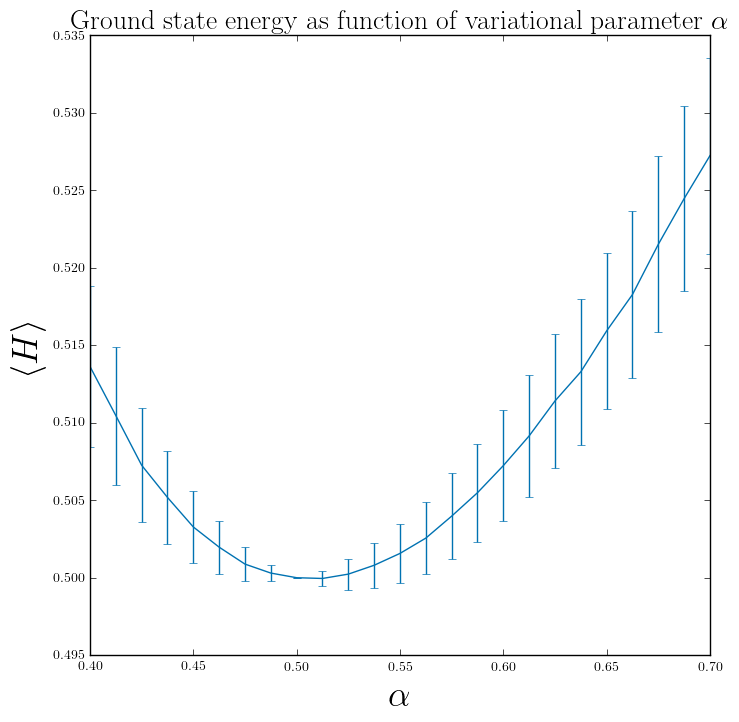

In [26]:
_ = proper_error_plot(np.linspace(0.4, 0.7, 25), importance=False, 
                      n_mc=2**20, dims=1, n=1)

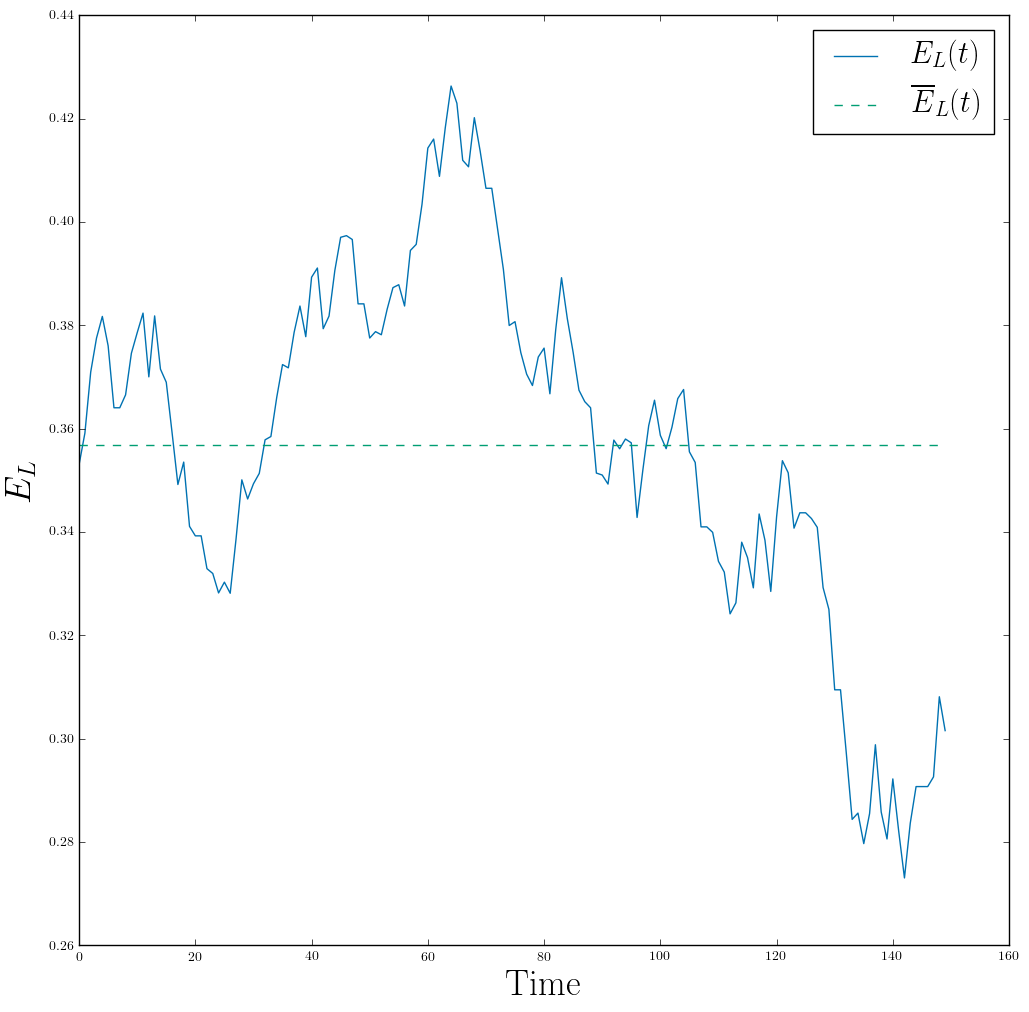

0.499728642382


In [5]:
E, _ = run_MC(n=1, dims=1, n_mc=2**18, alpha=0.55, importance=False)
time_series_plot(E[len(E) - 150:], saveas='../results/time-series-example.png')
print(np.mean(E))

[11] [12] [ 0.49988177] [ 0.]


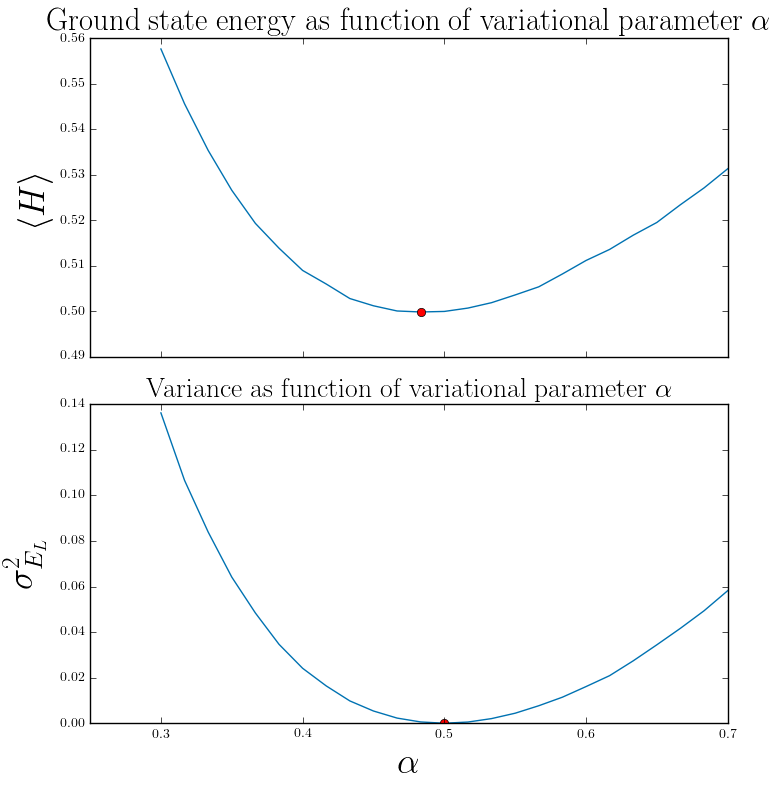

(array([[ 0.55760954,  0.54558268,  0.53535408,  0.52659946,  0.51932793,
          0.51388872,  0.5090005 ,  0.50601976,  0.50283157,  0.50124049,
          0.50010121,  0.49988177,  0.5       ,  0.50073836,  0.50192235,
          0.50362077,  0.50540479,  0.50822207,  0.51118022,  0.51361239,
          0.51673622,  0.51953062,  0.52343363,  0.52712039,  0.53131669]]),
 array([[ 0.1362306 ,  0.10662374,  0.08394365,  0.06415556,  0.0483934 ,
          0.0346497 ,  0.02411888,  0.01637609,  0.00978771,  0.00536221,
          0.00225539,  0.0005554 ,  0.        ,  0.00051387,  0.00202897,
          0.00439219,  0.00767511,  0.01142419,  0.01607986,  0.02088522,
          0.027396  ,  0.03442763,  0.04168209,  0.04937123,  0.05818609]]))

In [31]:
E_and_var_plot_for_alphas(np.linspace(0.3, 0.7, 25), 
                          n_mc=int(1e5), importance=False, steps=[1])

In [4]:
E_and_var_plot_for_alphas(np.linspace(0.3, 0.7, 25), 
                          n_mc=int(1e4), importance=False, 
                          saveas='../results/var-alpha-plot-noimp-10000-2.png')

TypeError: run_MC() got an unexpected keyword argument 'dt'

[12 12 14 18  3] [12 12 12 12 12]


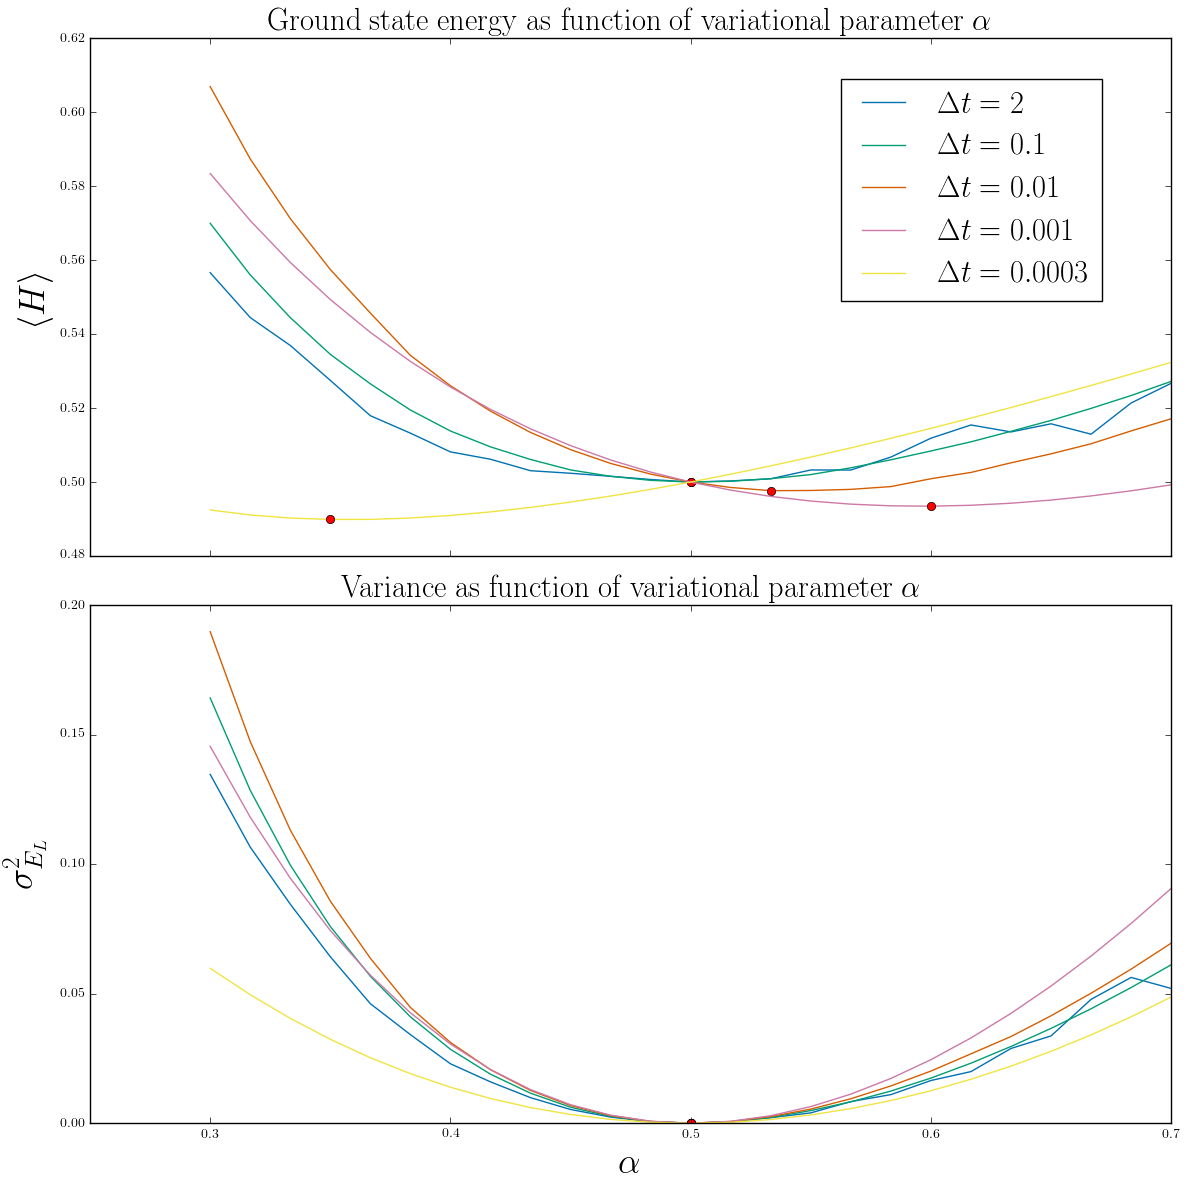

In [7]:
E_and_var_plot_for_alphas(np.linspace(0.3, 0.7, 25), 
                          n_mc=int(1e4), importance=True, dts=[2, 0.1, 0.01, 0.001, 0.0003],
                          saveas='../results/var-alpha-plot-imp-dts-10000.png')

In [63]:
s = np.array([[0.50833829,  0.07732213,  0.69294646],
              [0.63837196,  0.48833327,  0.17570063],
              [0.72436579,  0.36970369,  0.49771584],
              [0.42984966,  0.72519657,  0.30454728]])
- np.sum(s[:,0]**2 + s[:,1]**2 + 2.8*s[:,2]**2)
s = np.arange(1, 7).reshape(3, 2)
-np.sum(s[:,0]**2+s[:,1]**2)

-91

In [76]:
# Do not run this cell if you don't need to. It takes a while...
make_configuration_table('../results/vmc_configurations.csv', n_mc=100)
make_configuration_table('../results/vmc_imp_configurations.csv', n_mc=100, importance=True, dts=(1, 0.1, 0.01))

Dims, Number of particles, Analytic, Energy, Variance, Acceptance rate, Time spent
1,   1, OFF, 4.999999e-01, 2.468504e-15, 0.82, 6.00e-05
1,   1, ON , 5.000000e-01, 0.000000e+00, 0.82, 4.80e-05
1,  10, OFF, 5.000000e+00, 1.110006e-13, 0.88, 2.34e-03
1,  10, ON , 5.000000e+00, 9.624103e-32, 0.88, 5.34e-04
1, 100, OFF, 5.000000e+01, 2.618902e-12, 0.87, 7.66e-01
1, 100, ON , 5.000000e+01, 4.143476e-29, 0.87, 3.15e-02
1, 500, OFF, 2.500000e+02, 4.534363e-11, 0.86, 8.73e+01
1, 500, ON , 2.500000e+02, 4.204242e-27, 0.86, 7.74e-01
2,   1, OFF, 9.999999e-01, 9.514142e-15, 0.81, 5.30e-05
2,   1, ON , 1.000000e+00, 0.000000e+00, 0.81, 3.50e-05
2,  10, OFF, 9.999999e+00, 2.095685e-13, 0.79, 3.19e-03
2,  10, ON , 1.000000e+01, 2.871454e-31, 0.79, 4.58e-04
2, 100, OFF, 9.999999e+01, 9.343919e-12, 0.80, 1.77e+00
2, 100, ON , 1.000000e+02, 2.646736e-28, 0.80, 3.58e-02
2, 500, OFF, 5.000000e+02, 2.731972e-10, 0.79, 2.05e+02
2, 500, ON , 5.000000e+02, 1.681820e-26, 0.79, 8.89e-01
3,   1, OFF, 1.500000